# Gene Expression and RPPA Concordance 
Identify relationship between gene expression data and Reverse phase protein lysate microarray (RPPA) data 

## Inputs and Functions

In [58]:
import rnaseq_lib as r
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [117]:
# RPPA Data
rppa_path = './data/rppa.tsv'
rppa = pd.read_csv(rppa_path, sep='\t', index_col=0)
# Shorten TCGA sample names to 15 char limit
rppa.index = [x[:15] for x in rppa.index]  

# Gene Expression Data
# Synapse ID: syn12009613
data_path = '/mnt/data/Objects/tcga_gtex_data.hd5'
exp = pd.read_hdf(data_path, key='exp').apply(r.math.l2norm)
met = pd.read_hdf(data_path, key='met')
df = r.data.add_metadata_to_exp(exp, met)

# Subset for TCGA Tumor
tcga = exp.loc[[x for x in df.index if 
                x.startswith('TCGA') and x.endswith('01')]]
# Subset for GTEx for comparison
gtex = exp.loc[[x for x in df.index if x.startswith('GTEX')]]

# Normalize to log2(x + 0.001)
tcga = tcga.apply(r.math.l2norm)
gtex = gtex.apply(r.math.l2norm)

In [118]:
# Add a few differnetly labelled examples
rppa['ERBB2'] = rppa['HER2']
rppa['KDR'] = rppa['VEGFR2']

In [119]:
for x in [tcga, rppa]:
    print 'Samples: {}\tGenes: {}'.format(*x.shape)

Samples: 9164	Genes: 58581
Samples: 7754	Genes: 261


In [120]:
def create_plot_df(gene, rppa=rppa, tcga=tcga, df=df):
    pdf = pd.DataFrame()
    pdf['RPPA'] = rppa[gene].dropna()
    pdf['TCGA'] = tcga[gene].dropna()
    pdf['GTEX'] = gtex[gene].dropna()
    pdf['Tissue'] = df.tissue
    pdf['Tumor'] = df.tumor
    return pdf

In [121]:
def jointplot(gene, rppa=rppa, tcga=tcga):
    df = create_plot_df(gene, rppa=rppa, tcga=tcga)
    sns.jointplot(x='RPPA', y='TCGA', data=df, 
                  kind='reg', scatter_kws={'alpha':0.3})

## Subset By Sample and Gene Intersection

In [122]:
rppa_genes = set(rppa.columns[1:])
all_genes = set(df.columns)
genes = rppa_genes.intersection(all_genes)
print 'Number of genes in both datasets: {}'.format(len(genes))

Number of genes in both datasets: 89


In [123]:
samples = sorted(set(tcga.index).intersection(set(rppa.index)))
print 'Number of shared samples: {}'.format(len(samples))

Number of shared samples: 6553


In [124]:
tcga = tcga.loc[samples][sorted(genes)]
rppa = rppa.loc[samples][sorted(genes)]

## PearsonR Concordance

What is the general concordance relationship between RPPA and RNA-seq TPM data?

In [125]:
genes = sorted(genes)
pr = {}
for g in genes:
    t = create_plot_df(g)
    pr[g] = round(pearsonr(t.RPPA, t.TCGA)[0], 2)
pr = pd.Series(pr).sort_values()

In [ ]:
sns.boxplot(pr)
plt.xlabel('PearsonR Score')
plt.title('PearsonR Gene Scores Between RPPA and RNA-Seq');

Subset top 20 most concordant values

In [ ]:
sub = pr.tail(20)
plt.figure(figsize=(8, 4))
plt.scatter(sub.index, sub)
plt.xticks(rotation=45, fontsize=10);

## Concordance Evaluation

### HER2/ERBB2

In [ ]:
breast = df[(df.tissue == 'Breast') & (df.tumor == 'yes')]

In [ ]:
erbb2_c = r.math.overlay_gmm_to_hist(breast.ERBB2)

In [ ]:
print len(breast)
print len(breast[breast.ERBB2 > erbb2_c])

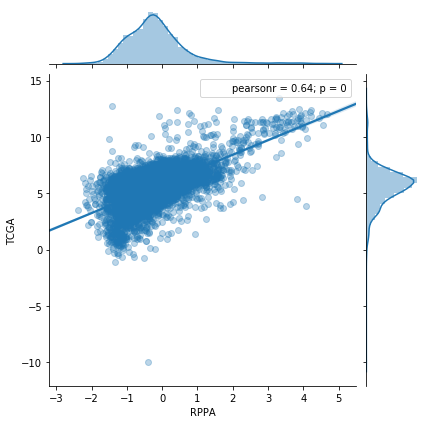

In [79]:
jointplot('ERBB2')